In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, AutoModel, AutoConfig,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# =============================================================================
# 1. DATA LOADING AND PREPROCESSING
# =============================================================================

def load_and_preprocess_data():
    """Load and preprocess all datasets"""
    print("Loading datasets...")

    # Load datasets
    train_df = pd.read_csv('train_en.tsv', sep='\t')
    dev_df = pd.read_csv('dev_en.tsv', sep='\t')
    test_df = pd.read_csv('test_en_labeled.tsv', sep='\t')

    print(f"Train samples: {len(train_df)}")
    print(f"Dev samples: {len(dev_df)}")
    print(f"Test samples: {len(test_df)}")

    # Convert labels to binary (SUBJ=1, OBJ=0)
    label_map = {'SUBJ': 1, 'OBJ': 0}
    train_df['label_num'] = train_df['label'].map(label_map)
    dev_df['label_num'] = dev_df['label'].map(label_map)
    test_df['label_num'] = test_df['label'].map(label_map)

    # Print label distribution
    print("\nLabel distribution:")
    print("Train:", train_df['label'].value_counts())
    print("Dev:", dev_df['label'].value_counts())
    print("Test:", test_df['label'].value_counts())

    return train_df, dev_df, test_df

In [ ]:
# =============================================================================
# 2. CUSTOM DATASET CLASS
# =============================================================================

class SubjectivityDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize with attention mask
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# =============================================================================
# 3. ADVANCED MODEL WITH NOVEL TECHNIQUES
# =============================================================================

class AdvancedSubjectivityClassifier(nn.Module):
    def __init__(self, model_name, num_classes=2, dropout_rate=0.3):
        super().__init__()

        # Load pre-trained model
        self.config = AutoConfig.from_pretrained(model_name)
        self.roberta = AutoModel.from_pretrained(model_name)

        # Multi-sample Dropout (Novel Technique 1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)

        # Multi-head classification (Novel Technique 2)
        hidden_size = self.config.hidden_size

        # Multiple classification heads for ensemble
        self.classifier1 = nn.Linear(hidden_size, num_classes)
        self.classifier2 = nn.Linear(hidden_size, num_classes)
        self.classifier3 = nn.Linear(hidden_size, num_classes)

        # Additional layers for better representation
        self.fc = nn.Linear(hidden_size, hidden_size // 2)
        self.final_classifier = nn.Linear(hidden_size // 2, num_classes)
        self.relu = nn.ReLU()

        # Layer normalization
        self.layer_norm = nn.LayerNorm(hidden_size)

    def forward(self, input_ids, attention_mask, training=True):
        # Get RoBERTa outputs
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output

        # Apply layer normalization
        pooled_output = self.layer_norm(pooled_output)

        if training:
            # Multi-sample Dropout during training
            logits1 = self.classifier1(self.dropout1(pooled_output))
            logits2 = self.classifier2(self.dropout2(pooled_output))
            logits3 = self.classifier3(self.dropout3(pooled_output))

            # Ensemble of multiple heads
            ensemble_logits = (logits1 + logits2 + logits3) / 3.0

            # Additional path
            hidden = self.relu(self.fc(pooled_output))
            main_logits = self.final_classifier(hidden)

            # Combine ensemble and main logits
            final_logits = (ensemble_logits + main_logits) / 2.0

            return final_logits
        else:
            # Inference: use average of multiple forward passes
            logits_list = []
            for _ in range(5):  # Multiple forward passes
                logits1 = self.classifier1(self.dropout1(pooled_output))
                logits2 = self.classifier2(self.dropout2(pooled_output))
                logits3 = self.classifier3(self.dropout3(pooled_output))
                ensemble_logits = (logits1 + logits2 + logits3) / 3.0

                hidden = self.relu(self.fc(pooled_output))
                main_logits = self.final_classifier(hidden)
                final_logits = (ensemble_logits + main_logits) / 2.0

                logits_list.append(final_logits)

            # Average multiple forward passes
            return torch.stack(logits_list).mean(dim=0)

In [ ]:
# =============================================================================
# 4. FOCAL LOSS (Novel Technique 3)
# =============================================================================

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:

# =============================================================================
# 5. TRAINING FUNCTION
# =============================================================================

def train_model(model, train_loader, dev_loader, num_epochs=4, learning_rate=2e-5):
    """Train the model with advanced techniques"""

    # Optimizer with different learning rates for different layers
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {
            'params': [p for n, p in model.named_parameters()
                      if not any(nd in n for nd in no_decay)],
            'weight_decay': 0.01,
            'lr': learning_rate
        },
        {
            'params': [p for n, p in model.named_parameters()
                      if any(nd in n for nd in no_decay)],
            'weight_decay': 0.0,
            'lr': learning_rate * 2  # Higher LR for bias and LayerNorm
        }
    ]

    optimizer = AdamW(optimizer_grouped_parameters)

    # Learning rate scheduler
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=total_steps * 0.1,  # 10% warmup
        num_training_steps=total_steps
    )

    # Focal Loss for handling class imbalance
    criterion = FocalLoss(alpha=1, gamma=2)

    model.train()
    best_f1 = 0
    best_model_state = None

    for epoch in range(num_epochs):
        total_loss = 0
        model.train()

        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            logits = model(input_ids, attention_mask, training=True)
            loss = criterion(logits, labels)

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()

            total_loss += loss.item()

        # Validation
        val_acc, val_f1 = evaluate_model(model, dev_loader)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {total_loss/len(train_loader):.4f}")
        print(f"Val Accuracy: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        # Save best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_state = model.state_dict().copy()

        print("-" * 50)

    # Load best model
    model.load_state_dict(best_model_state)
    return model

In [ ]:
# =============================================================================
# 6. EVALUATION FUNCTION
# =============================================================================

def evaluate_model(model, data_loader):
    """Evaluate model performance"""
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            logits = model(input_ids, attention_mask, training=False)

            # Get predictions
            preds = torch.argmax(logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')

    return accuracy, f1

Loading datasets...
Train samples: 830
Dev samples: 462
Test samples: 300

Label distribution:
Train: label
OBJ     532
SUBJ    298
Name: count, dtype: int64
Dev: label
SUBJ    240
OBJ     222
Name: count, dtype: int64
Test: label
OBJ     215
SUBJ     85
Name: count, dtype: int64
Model parameters: 109,784,456

STARTING TRAINING
Epoch 1/4
Train Loss: 0.1489
Val Accuracy: 0.7554, Val F1: 0.7542
--------------------------------------------------
Epoch 2/4
Train Loss: 0.1119
Val Accuracy: 0.7035, Val F1: 0.6970
--------------------------------------------------
Epoch 3/4
Train Loss: 0.0732
Val Accuracy: 0.7597, Val F1: 0.7598
--------------------------------------------------
Epoch 4/4
Train Loss: 0.0498
Val Accuracy: 0.7662, Val F1: 0.7663
--------------------------------------------------

FINAL EVALUATION
Development Set - Accuracy: 0.7662, F1 Score: 0.7663
Test Set - Accuracy: 0.7400, F1 Score: 0.7400

Detailed Classification Report:
              precision    recall  f1-score   suppor

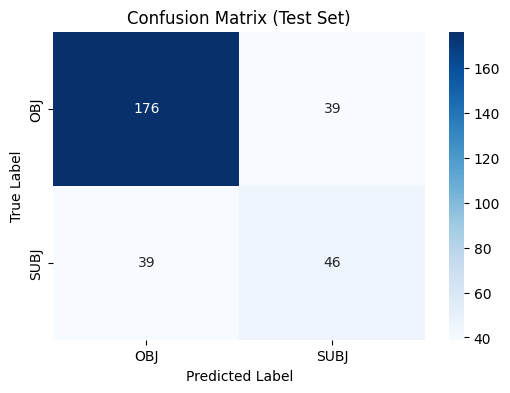


Model saved as 'best_subjectivity_model.pth'


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# =============================================================================
# 7. MAIN EXECUTION
# =============================================================================

def main():
    """Main execution function"""

    # Load data
    train_df, dev_df, test_df = load_and_preprocess_data()

    # Initialize tokenizer (RoBERTa - best for text classification)
    model_name = "bert-base-uncased"  # You can also try "roberta-large"
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Create datasets
    train_dataset = SubjectivityDataset(
        train_df['sentence'].values,
        train_df['label_num'].values,
        tokenizer
    )

    dev_dataset = SubjectivityDataset(
        dev_df['sentence'].values,
        dev_df['label_num'].values,
        tokenizer
    )

    test_dataset = SubjectivityDataset(
        test_df['sentence'].values,
        test_df['label_num'].values,
        tokenizer
    )

    # Create data loaders
    batch_size = 16  # Adjust based on your GPU memory

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model
    model = AdvancedSubjectivityClassifier(model_name)
    model.to(device)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Train model
    print("\n" + "="*60)
    print("STARTING TRAINING")
    print("="*60)

    trained_model = train_model(model, train_loader, dev_loader)

    # Final evaluation
    print("\n" + "="*60)
    print("FINAL EVALUATION")
    print("="*60)

    # Development set evaluation
    dev_acc, dev_f1 = evaluate_model(trained_model, dev_loader)
    print(f"Development Set - Accuracy: {dev_acc:.4f}, F1 Score: {dev_f1:.4f}")

    # Test set evaluation
    test_acc, test_f1 = evaluate_model(trained_model, test_loader)
    print(f"Test Set - Accuracy: {test_acc:.4f}, F1 Score: {test_f1:.4f}")

    # Detailed classification report for test set
    trained_model.eval()
    test_predictions = []
    test_true_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = trained_model(input_ids, attention_mask, training=False)
            preds = torch.argmax(logits, dim=1)

            test_predictions.extend(preds.cpu().numpy())
            test_true_labels.extend(labels.cpu().numpy())

    # Print detailed results
    print("\nDetailed Classification Report:")
    target_names = ['OBJ', 'SUBJ']
    print(classification_report(test_true_labels, test_predictions, target_names=target_names))

    # Print Confusion Matrix for test set
    print("\nConfusion Matrix:")
    cm = confusion_matrix(test_true_labels, test_predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()

    # Save model
    torch.save(trained_model.state_dict(), 'best_subjectivity_model.pth')
    print("\nModel saved as 'best_subjectivity_model.pth'")

if __name__ == "__main__":
    main()

Loading datasets...
Train samples: 830
Dev samples: 462
Test samples: 300

Label distribution:
Train: label
OBJ     532
SUBJ    298
Name: count, dtype: int64
Dev: label
SUBJ    240
OBJ     222
Name: count, dtype: int64
Test: label
OBJ     215
SUBJ     85
Name: count, dtype: int64


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 355,893,768

STARTING TRAINING
Epoch 1/4
Train Loss: 0.1667
Val Accuracy: 0.6126, Val F1: 0.5787
--------------------------------------------------
Epoch 2/4
Train Loss: 0.1296
Val Accuracy: 0.7229, Val F1: 0.7209
--------------------------------------------------
Epoch 3/4
Train Loss: 0.0818
Val Accuracy: 0.6385, Val F1: 0.6048
--------------------------------------------------
Epoch 4/4
Train Loss: 0.0422
Val Accuracy: 0.7814, Val F1: 0.7803
--------------------------------------------------

FINAL EVALUATION
Development Set - Accuracy: 0.7814, F1 Score: 0.7803
Test Set - Accuracy: 0.8300, F1 Score: 0.8229

Detailed Classification Report:
              precision    recall  f1-score   support

         OBJ       0.85      0.93      0.89       215
        SUBJ       0.76      0.59      0.66        85

    accuracy                           0.83       300
   macro avg       0.80      0.76      0.77       300
weighted avg       0.82      0.83      0.82       300


Confu

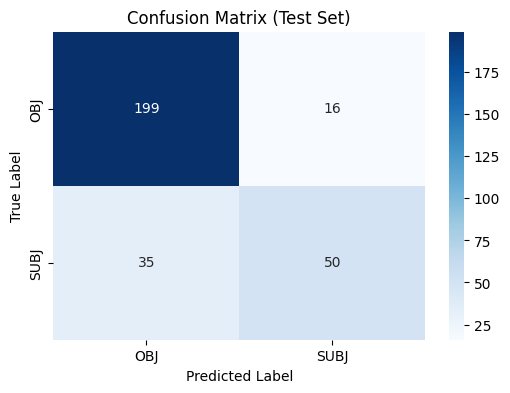


Model saved as 'best_subjectivity_model.pth'


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# =============================================================================
# 7. MAIN EXECUTION
# =============================================================================

def main():
    """Main execution function"""

    # Load data
    train_df, dev_df, test_df = load_and_preprocess_data()

    # Initialize tokenizer (RoBERTa - best for text classification)
    model_name = "roberta-large"  # You can also try "roberta-large"
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Create datasets
    train_dataset = SubjectivityDataset(
        train_df['sentence'].values,
        train_df['label_num'].values,
        tokenizer
    )

    dev_dataset = SubjectivityDataset(
        dev_df['sentence'].values,
        dev_df['label_num'].values,
        tokenizer
    )

    test_dataset = SubjectivityDataset(
        test_df['sentence'].values,
        test_df['label_num'].values,
        tokenizer
    )

    # Create data loaders
    batch_size = 16  # Adjust based on your GPU memory

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model
    model = AdvancedSubjectivityClassifier(model_name)
    model.to(device)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Train model
    print("\n" + "="*60)
    print("STARTING TRAINING")
    print("="*60)

    trained_model = train_model(model, train_loader, dev_loader)

    # Final evaluation
    print("\n" + "="*60)
    print("FINAL EVALUATION")
    print("="*60)

    # Development set evaluation
    dev_acc, dev_f1 = evaluate_model(trained_model, dev_loader)
    print(f"Development Set - Accuracy: {dev_acc:.4f}, F1 Score: {dev_f1:.4f}")

    # Test set evaluation
    test_acc, test_f1 = evaluate_model(trained_model, test_loader)
    print(f"Test Set - Accuracy: {test_acc:.4f}, F1 Score: {test_f1:.4f}")

    # Detailed classification report for test set
    trained_model.eval()
    test_predictions = []
    test_true_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = trained_model(input_ids, attention_mask, training=False)
            preds = torch.argmax(logits, dim=1)

            test_predictions.extend(preds.cpu().numpy())
            test_true_labels.extend(labels.cpu().numpy())

    # Print detailed results
    print("\nDetailed Classification Report:")
    target_names = ['OBJ', 'SUBJ']
    print(classification_report(test_true_labels, test_predictions, target_names=target_names))

    # Print Confusion Matrix for test set
    print("\nConfusion Matrix:")
    cm = confusion_matrix(test_true_labels, test_predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()

    # Save model
    torch.save(trained_model.state_dict(), 'best_subjectivity_model.pth')
    print("\nModel saved as 'best_subjectivity_model.pth'")

if __name__ == "__main__":
    main()

Loading datasets...
Train samples: 830
Dev samples: 462
Test samples: 300

Label distribution:
Train: label
OBJ     532
SUBJ    298
Name: count, dtype: int64
Dev: label
SUBJ    240
OBJ     222
Name: count, dtype: int64
Test: label
OBJ     215
SUBJ     85
Name: count, dtype: int64


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 124,947,848

STARTING TRAINING
Epoch 1/4
Train Loss: 0.1547
Val Accuracy: 0.7532, Val F1: 0.7480
--------------------------------------------------
Epoch 2/4
Train Loss: 0.1148
Val Accuracy: 0.7576, Val F1: 0.7547
--------------------------------------------------
Epoch 3/4
Train Loss: 0.0686
Val Accuracy: 0.7619, Val F1: 0.7583
--------------------------------------------------
Epoch 4/4
Train Loss: 0.0465
Val Accuracy: 0.7944, Val F1: 0.7939
--------------------------------------------------

FINAL EVALUATION
Development Set - Accuracy: 0.7944, F1 Score: 0.7939
Test Set - Accuracy: 0.8133, F1 Score: 0.8119

Detailed Classification Report:
              precision    recall  f1-score   support

         OBJ       0.86      0.88      0.87       215
        SUBJ       0.68      0.65      0.66        85

    accuracy                           0.81       300
   macro avg       0.77      0.76      0.77       300
weighted avg       0.81      0.81      0.81       300


Confu

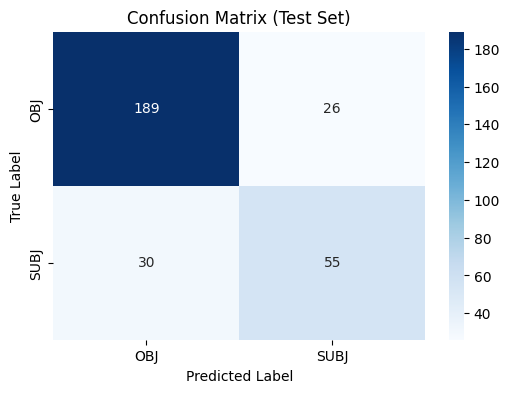


Model saved as 'best_subjectivity_model.pth'


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# =============================================================================
# 7. MAIN EXECUTION
# =============================================================================

def main():
    """Main execution function"""

    # Load data
    train_df, dev_df, test_df = load_and_preprocess_data()

    # Initialize tokenizer (RoBERTa - best for text classification)
    model_name = "roberta-base"  # You can also try "roberta-large"
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Create datasets
    train_dataset = SubjectivityDataset(
        train_df['sentence'].values,
        train_df['label_num'].values,
        tokenizer
    )

    dev_dataset = SubjectivityDataset(
        dev_df['sentence'].values,
        dev_df['label_num'].values,
        tokenizer
    )

    test_dataset = SubjectivityDataset(
        test_df['sentence'].values,
        test_df['label_num'].values,
        tokenizer
    )

    # Create data loaders
    batch_size = 16  # Adjust based on your GPU memory

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model
    model = AdvancedSubjectivityClassifier(model_name)
    model.to(device)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Train model
    print("\n" + "="*60)
    print("STARTING TRAINING")
    print("="*60)

    trained_model = train_model(model, train_loader, dev_loader)

    # Final evaluation
    print("\n" + "="*60)
    print("FINAL EVALUATION")
    print("="*60)

    # Development set evaluation
    dev_acc, dev_f1 = evaluate_model(trained_model, dev_loader)
    print(f"Development Set - Accuracy: {dev_acc:.4f}, F1 Score: {dev_f1:.4f}")

    # Test set evaluation
    test_acc, test_f1 = evaluate_model(trained_model, test_loader)
    print(f"Test Set - Accuracy: {test_acc:.4f}, F1 Score: {test_f1:.4f}")

    # Detailed classification report for test set
    trained_model.eval()
    test_predictions = []
    test_true_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = trained_model(input_ids, attention_mask, training=False)
            preds = torch.argmax(logits, dim=1)

            test_predictions.extend(preds.cpu().numpy())
            test_true_labels.extend(labels.cpu().numpy())

    # Print detailed results
    print("\nDetailed Classification Report:")
    target_names = ['OBJ', 'SUBJ']
    print(classification_report(test_true_labels, test_predictions, target_names=target_names))

    # Print Confusion Matrix for test set
    print("\nConfusion Matrix:")
    cm = confusion_matrix(test_true_labels, test_predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()

    # Save model
    torch.save(trained_model.state_dict(), 'best_subjectivity_model.pth')
    print("\nModel saved as 'best_subjectivity_model.pth'")

if __name__ == "__main__":
    main()